# RGB Images

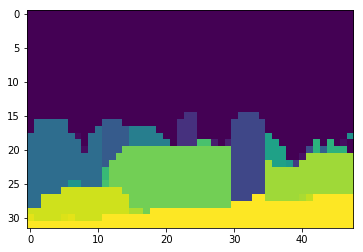

(321, 481, 3)

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import rescale
import numpy as np
import scipy.io as sio
import os

# Path of images
path = 'C:/Users/DarkB/Downloads/ML Python Scripts/Project 1/ImsAndSegs'

# Load image data
img_load = sio.loadmat('C:/Users/DarkB/Downloads/ML Python Scripts/Project 1/ImsAndSegs/ImsAndTruths97017.mat')
img = img_load['Im']
seg_im = img_load['Seg1']

# Plot image
plt.imshow(rescale(seg_im,0.1,mode='reflect'))
plt.show()
img.shape

In [2]:
import numpy as np
import scipy.io as sio
import time
import sys
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from minisom import MiniSom
import skfuzzy
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
from sklearn import mixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from skimage.transform import rescale


def MyKmeans8(Image, ImageType, NumClusts):
    # Loads the image
    image_ = sio.loadmat(Image)
    im_keys = image_.keys()
    if 'Im' in im_keys:
        im = image_['Im']
    elif 'PaviaHyperIm' in im_keys:
        im = image_['PaviaHyperIm']
    elif 'SanBarIm88x400' in im_keys:
        im = image_['SanBarIm88x400']
    # #########################################################################
    # #########################################################################

    # Rescaling and Reshaping for RGB or HyperSepctral
    if ImageType == "RGB":
        im_down = rescale(im, 0.25, mode='reflect')
        data = im_down.reshape(im_down.shape[0] * im_down.shape[1], 3)
    elif ImageType == "Hyper":
        # Reshape to 2D - one column per component
        data_r = im.reshape(im.shape[0] * im.shape[1], im.shape[2])

        # Using PCA
        pca = PCA().fit(data_r)
        cum_var = np.cumsum(pca.explained_variance_ratio_)

        for count, var in enumerate(cum_var):
            if var >= 0.95:
                n_components = count+1
                break
        pca = PCA(n_components=n_components)
        reduced_data = pca.fit_transform(data_r)

        # Since my data is not between [0,1], I rescale the data
        min_max_scaler = MinMaxScaler()
        reduced_data_scaled = min_max_scaler.fit_transform(reduced_data)

        # Turn data back into 3 dimensions to control
        # the downsampling of the data
        # reduced_data_3D = reduced_data_scaled.reshape(im[:, :, 0:3].shape)
        im_down = reduced_data_scaled.reshape(im[:, :, 0:3].shape)
        # im_down = rescale(reduced_data_3D, 0.1, mode='reflect')
        # Flatten my data agan for algorithm input
        # data = im_down.reshape(im_down.shape[0] * im_down.shape[1], 3)
        data = reduced_data_scaled
    else:
        print ("Wrong ImageType")
        sys.exit()
    # #########################################################################
    # #########################################################################

    # Cluster Selection Logic Goes Here
    # #########################################################################
    # #########################################################################

    # Clustering algorithm goes here
    t0 = time.time()

    # Initializing KMeans
    kmeans = KMeans(n_clusters=NumClusts)

    # Fitting with inputs
    kmeans.fit(data)

    # Finding lables for inputs
    labels = kmeans.predict(data)

    # Find corresponding center to data
    clusters = kmeans.cluster_centers_[labels]

    # End Clustering
    t1 = time.time()

    # Reshape data to 3D
    img_clustered = clusters.reshape(im_down.shape)

    # Plot data
    # title = 'KMeans clustering time to do: %.2fs' % (t1 - t0)
    # print(title)
    # plt.imshow(clustered)
    # plt.show()
    # #########################################################################
    # #########################################################################

    if ImageType == "Hyper":
        return img_clustered
    else:
        """ build connected components and return clustered image and CCIm """
        # Step 1 - Binary Clusters Images

        # Separate the clusters into binary images --> This step need to be transformed into a function
        # that takes the number of clusters selected and separete into a binary image for each cluster
        # Currently only works for ONE of the clusters
        def smoothing(clusters, sigma_gaussian=0.5, window_size=5, remove_small=10):
            img_clustered = clusters.reshape(im_down.shape)
            first_cluster = np.copy(clusters)
            mySet = set()
            for i in range(len(img_clustered)):
                for j in range(len(img_clustered[0])):
                    mySet.add(tuple(img_clustered[i][j].tolist()))

            canvas = [np.array([-1, -1, -1]) for j in range(len(first_cluster))]
            canvas2 = [0 for j in range(len(first_cluster))]
            s = 1
            for color in mySet:
                for k in range(len(canvas2)):
                    if np.array_equal(img_clustered[i][j], np.asarray(list(color))):
                        canvas2[k] = s
                s += 1
            # print(len(images),len(img_clustered)*len(img_clustered[0]))

            def canvasUpdate(image1, canvas, l):
                k = 0
                for i in range(len(img_clustered)):
                    for j in range(len(img_clustered[0])):
                        if np.array_equal(canvas[k], np.array([-1, -1, -1])):
                            if np.array_equal(image1[k], np.array([1, 1, 1])):
                                canvas[k] = np.array([l, l, l])
                        k += 1

            def extractSegment(color):
                tempImage = [np.array([-1, -1, -1]) for j in range(len(first_cluster))]
                k = 0
                for i in range(len(img_clustered)):
                    for j in range(len(img_clustered[0])):
                        if np.array_equal(img_clustered[i][j], np.asarray(list(color))):
                            tempImage[k] = np.array([1, 1, 1])
                        k += 1
                return tempImage

            def segmentSmooth(image2):

                first_cluster = np.asarray(image2)
                cluster_1 = (first_cluster.reshape(im_down.shape))

                # Step 2 - Label Connected Components

                # The connected components are labeled based on connected regions assiging the same integer value, based on 4 neighbors (default)
                # This needs to be set within the funtion that evaluates each binary cluster image to label its connected components
                # Reference: http://scikit-image.org/docs/dev/api/skimage.measure.html

                img_flat = first_cluster
                all_labels = measure.label(img_flat)
                img_labeled_by_components = all_labels.reshape(img_clustered.shape)

                # Step 3 - Remove Small Connected Components

                # Remove connected components smaller than the specified size, in this case i picked 10 but this might change
                # and reconver the image from labels into binary. Agains need to be placed into the generalized function
                # Reference: http://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects

                clean_cluster = morphology.remove_small_objects(
                    img_labeled_by_components, remove_small)
                clean_cluster[clean_cluster > 1] = 1
                clean_cluster = clean_cluster.astype(float)
                #clean_cluster = img_labeled_by_components
                # Step 4 - Smoothing Image

                # The cleaned image is passed through a gaussing filter to smooth the output, it is not entirelly clear to me how it works
                # so we might or mightn ot use this step

                img_flat_clean = clean_cluster.reshape(
                    clean_cluster.shape[0] * clean_cluster.shape[1], 3)

                s = sigma_gaussian  # sigma
                w = window_size  # window size
                t = (((w - 1)/2)-0.5)/s  # truncate

                blurred = gaussian_filter(img_flat_clean, sigma=s, order=0, truncate=t)
                blobs = blurred > 0.91 * blurred.mean()

                img_cluster_filt = blobs.reshape(img_clustered.shape)

                return img_cluster_filt.astype(int)

            l = 1

            for color in mySet:
                image3 = extractSegment(color)
                image4 = segmentSmooth(image3)
                image4 = image4.reshape(first_cluster.shape)
                canvasUpdate(image4, canvas, l)
                l += 1

            for i in range(len(canvas)):
                if not np.array_equal(canvas[i], np.array([-1, -1, -1])):
                    canvas2[i] = canvas[i][0]
            canvasFinal = np.asarray(canvas).reshape(img_clustered.shape)
            canvas3 = np.asarray(canvas2).reshape((img_clustered.shape[0], img_clustered.shape[1]))
            plt.imshow(canvas3)
            plt.show()
            img.shape
            return canvas3
        smoothImage = smoothing(clusters)
        return img_clustered, smoothImage

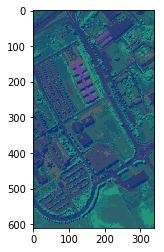

In [10]:
x = MyKmeans8('PaviaHyperIm', 'Hyper', 9)
plt.imshow(x)
plt.show()

In [11]:
hgtruth_load = sio.loadmat('PaviaGrTruth.mat')
hgtruth_mask = hgtruth_load['PaviaGrTruth']

print(martinIndex(hgtruth_mask, x)*1000) # This is the smooth

881.6210693524073


## K-Means Algorithm Implementation

In [2]:
import time
import numpy as np
from sklearn.cluster import KMeans


#Downsample image
img_r = rescale(img,0.1,mode='reflect')
img_flat = img_r.reshape(img_r.shape[0] * img_r.shape[1], 3)
n_clusters = 3

t0 = time.time()
# Initializing KMeans
kmeans = KMeans(n_clusters = n_clusters)

# Fitting with inputs
kmeans = kmeans.fit(img_flat)
clusters = kmeans.cluster_centers_[kmeans.predict(img_flat)]
t1 = time.time()

# Reshape flattened image
img_clustered = clusters.reshape(img_r.shape)

# Plot image
plt.imshow(img_clustered)
title = 'KMeans clustering tie to do: %.2fs' % (t1 - t0)
print(title)
plt.show()

NameError: name 'rescale' is not defined

(32, 48, 3)


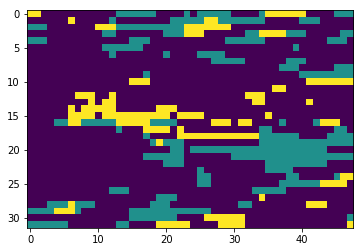

(321, 481, 3)

In [29]:
from skimage import measure
from skimage import morphology
from scipy.ndimage.filters import gaussian_filter


# Step 1 - Binary Clusters Images

# Separate the clusters into binary images --> This step need to be transformed into a function 
# that takes the number of clusters selected and separete into a binary image for each cluster
# Currently only works for ONE of the clusters

t0 = time.time()

first_cluster = np.copy(clusters)
#print(np.unique(img_clustered))
#print(img_clustered[20][0])
mySet = set()
for i in range(len(img_clustered)):
	for j in range(len(img_clustered[0])):
		mySet.add(tuple(img_clustered[i][j].tolist()))
#images = [[[[] for i in range(len(img_clustered[0]))] for l in range(len(img_clustered))] for k in range(3)]
canvas = [np.array([-1,-1,-1]) for j in range(len(first_cluster))]
canvas2 = [0 for j in range(len(first_cluster))]
s = 1
for color in mySet:
	for k in range(len(canvas2)):
		if np.array_equal(img_clustered[i][j], np.asarray(list(color))):
			canvas2[k] = s
	s+=1
#print(len(images),len(img_clustered)*len(img_clustered[0]))


def canvasUpdate(image1, canvas, l):
	k=0
	for i in range(len(img_clustered)):
		for j in range(len(img_clustered[0])):
			if 	np.array_equal(canvas[k], np.array([-1,-1,-1])):
				if np.array_equal(image1[k], np.array([1,1,1])):
					canvas[k] = np.array([l,l,l])
			k+=1

def extractSegment(color):
	tempImage = [np.array([-1,-1,-1]) for j in range(len(first_cluster))]
	k=0
	for i in range(len(img_clustered)):
		for j in range(len(img_clustered[0])):
			if np.array_equal(img_clustered[i][j], np.asarray(list(color))):
				tempImage[k] = np.array([1,1,1])
			k+=1
	return tempImage



def segmentSmooth(image2):

	first_cluster = np.asarray(image2)	
	cluster_1 = (first_cluster.reshape(img_r.shape))

	# Step 2 - Label Connected Components

	# The connected components are labeled based on connected regions assiging the same integer value, based on 4 neighbors (default)
	# This needs to be set within the funtion that evaluates each binary cluster image to label its connected components
	# Reference: http://scikit-image.org/docs/dev/api/skimage.measure.html

	img_flat = first_cluster
	all_labels = measure.label(img_flat)
	img_labeled_by_components = all_labels.reshape(img_clustered.shape)



	# Step 3 - Remove Small Connected Components

	# Remove connected components smaller than the specified size, in this case i picked 10 but this might change
	# and reconver the image from labels into binary. Agains need to be placed into the generalized function
	# Reference: http://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects


	clean_cluster = morphology.remove_small_objects(img_labeled_by_components, 10)
	clean_cluster[clean_cluster > 1] = 1
	clean_cluster = clean_cluster.astype(float)
	#clean_cluster = img_labeled_by_components
	# Step 4 - Smoothing Image

	# The cleaned image is passed through a gaussing filter to smooth the output, it is not entirelly clear to me how it works
	# so we might or mightn ot use this step


	img_flat_clean = clean_cluster.reshape(clean_cluster.shape[0] * clean_cluster.shape[1], 3)

	s = 0.5 # sigma
	w = 5 # window size
	t = (((w - 1)/2)-0.5)/s #truncate


	blurred = gaussian_filter(img_flat_clean, sigma=s, order=0, truncate=t)
	blobs = blurred > 0.91 * blurred.mean()

	img_cluster_filt = blobs.reshape(img_clustered.shape)

	return img_cluster_filt.astype(int)

l = 1

	
for color in mySet:
	image3 = extractSegment(color)
	image4 = segmentSmooth(image3)
	image4 = image4.reshape(first_cluster.shape)
	canvasUpdate(image4,canvas,l)
	l+=1

for i in range(len(canvas)):
    if not np.array_equal(canvas[i], np.array([-1,-1,-1])):
        canvas2[i] = canvas[i][0]
canvasFinal = np.asarray(canvas).reshape(img_clustered.shape)
print(img_clustered.shape)
canvas3 = np.asarray(canvas2).reshape((img_clustered.shape[0],img_clustered.shape[1]))
plt.imshow(canvas3)
plt.show()
img.shape

# Hyperspectral Images

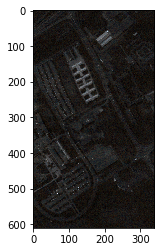

(610, 340, 3)

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.io as sio
import os


# hsimg_load = sio.loadmat('SanBarHyperIm.mat')
# hsimg_data = hsimg_load['SanBarIm88x400']
hsimg_load = sio.loadmat('PaviaHyperIm.mat')
hsimg_data = hsimg_load['PaviaHyperIm']
himage_display = hsimg_data[:,:,0:3]
plt.imshow(himage_display)
plt.show()
hsimg_data[:,:,0:3].shape

We need about 3 components to retain 95% of the variance


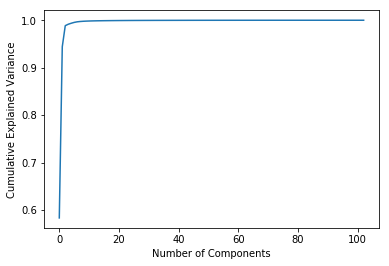

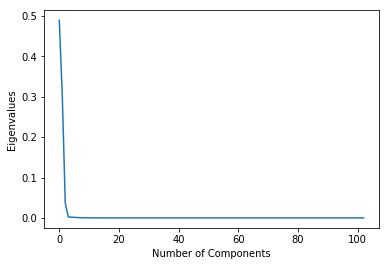

In [96]:
from sklearn.decomposition import PCA
data = hsimg_data.reshape(hsimg_data.shape[0] * hsimg_data.shape[1], hsimg_data.shape[2])
pca = PCA().fit(data)
cum_var = np.cumsum(pca.explained_variance_ratio_)
eigenvalues = pca.explained_variance_

count = 0
for var in cum_var:
    count += 1
    if var >= 0.95:
        n_components = count
        answer = "We need about "+ str(n_components) + " components to retain 95% of the variance"
        print(answer)
        break
        
plt.figure(1)
plt.plot(cum_var)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.figure(2)
plt.plot(eigenvalues)
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalues')
plt.show()

# Minumum Noise Factor --> Similar to PCA but removes noise from bands

In [97]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from skimage.transform import rescale
from sklearn.cluster import KMeans
import numpy as np
import time

#Reshape to 2D - one column per component
data = hsimg_data.reshape(hsimg_data.shape[0] * hsimg_data.shape[1], hsimg_data.shape[2])

#Using PCA
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(data)

#Since my data is not between [0,1], I rescale the data
min_max_scaler = MinMaxScaler()
reduced_data_scaled = min_max_scaler.fit_transform(reduced_data)

#Turn data back into 3 dimensions to control the downsampling of the data
reduced_data_3D = reduced_data_scaled .reshape(hsimg_data[:,:,0:3].shape)
# img_r = rescale(reduced_data_3D,0.1,mode='reflect')

#Flatten my data again for algorithm input
# img_data = img_r.reshape(img_r.shape[0] * img_r.shape[1], 3)
img_data = reduced_data_3D.reshape(reduced_data_3D.shape[0] * reduced_data_3D.shape[1], 3)

KMeans clustering time to do: 31.22s


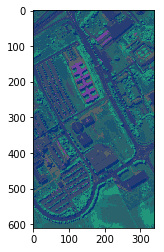

In [98]:
from sklearn.cluster import KMeans

n_clusters = 9

# Initializing KMeans
kmeans = KMeans(n_clusters=n_clusters)
# Fitting with inputs
t0 = time.time()

# Run algorithm
kmeans = kmeans.fit(img_data)
clusters = kmeans.cluster_centers_[kmeans.predict(img_data)]
t1 = time.time()

# Reshape the data into 3D
# img_clustered = clusters.reshape(img_r.shape)
img_clustered = clusters.reshape(reduced_data_3D.shape)

# Plot the data
plt.imshow(img_clustered)
title = 'KMeans clustering time to do: %.2fs' % (t1 - t0)
print(title)
plt.show()

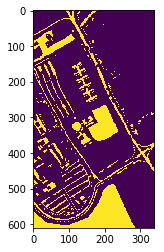

In [99]:
htruth_load = sio.loadmat('PaviaGrTruthMask.mat')
htruth_mask = htruth_load['PaviaGrTruthMask']
plt.imshow(htruth_mask)
plt.show()

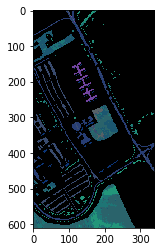

In [100]:
# create mask with same dimensions as image
mask = np.zeros_like(img_clustered)

# copy your image_mask to all dimensions (i.e. colors) of your image
for i in range(3): 
    mask[:,:,i] = htruth_mask.copy()

# apply the mask to your image
masked_image = img_clustered*mask

plt.imshow(masked_image)
plt.show()

In [101]:
hgtruth_load = sio.loadmat('PaviaGrTruth.mat')
hgtruth_mask = hgtruth_load['PaviaGrTruth']

martinIndex(hgtruth_mask, masked_image)*1000

163.0884271768798

In [8]:
from collections import defaultdict

def martinIndex(groundTruth, segmentedImage):
	def imageToHashSegmented(arr):
		myHash = {}
		for i in range(len(arr)):
			for j in range(len(arr[0])):
				tempTuple = tuple(arr[i][j].tolist())
				if tempTuple in myHash:
					myHash[tempTuple].add((i,j))
				else:
					myHash[tempTuple] = {(i,j)}
		return myHash
	def imageToHash(arr):
		myHash = {}
		for i in range(len(arr)):
			for j in range(len(arr[0])):
				if arr[i][j] in myHash:
					myHash[arr[i][j]].add((i,j))
				else:
					myHash[arr[i][j]] = {(i,j)}
		return myHash

	def WJ(hashGround):
		totalPixels = len(groundTruth) * len(groundTruth[0])
		wjHash = defaultdict(int)
		for x in hashGround:
			wjHash[x] = len(hashGround[x])/totalPixels
		return wjHash

	def WJI(hashGround, hashSegmented):
		wjiHash = defaultdict(int)
		wjiHashDen = defaultdict(int)
		for j in hashGround:
			for i in hashSegmented:
				if len(hashGround[j].intersection(hashSegmented[i])) > 0:
					intersection = 1
				else:
					intersection = 0
				wjiHash[(j,i)] = len(hashSegmented[i]) * intersection
				wjiHashDen[j] += len(hashSegmented[i]) * intersection
		for j in hashGround:
			for i in hashSegmented:
				wjiHash[(j,i)] /= wjiHashDen[j]
		return wjiHash

	def EGS(hashGround, hashSegmented):
		martinIndex = 0
		wji = WJI(hashGround, hashSegmented)
		wj = WJ(hashGround)
		for j in hashGround:
			innerSum = 1
			for i in hashSegmented:
				innerSum -= (len(hashGround[j].intersection(hashSegmented[i])) / len(hashGround[j].union(hashSegmented[i]))) * wji[(j,i)]
			innerSum *= wj[j]
			martinIndex += innerSum
		return martinIndex
	if segmentedImage[0][0].size>1:
		return EGS(imageToHash(groundTruth), imageToHashSegmented(segmentedImage))        
	return EGS(imageToHash(groundTruth), imageToHash(segmentedImage))

Self-Organizing Map clustering time to do: 11.15s


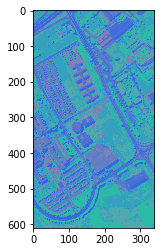

In [103]:
from minisom import MiniSom

n_clusters = 9

t0 = time.time()
#Run Algorithm
som = MiniSom(1, n_clusters, 3, sigma=0.1, learning_rate=0.2)  # 3x1 = 3 final colors
som.random_weights_init(img_data)
starting_weights = som.get_weights().copy()  # saving the starting weights
som.train_random(img_data, 100)

qnt = som.quantization(img_data)  # quantize each pixels of the image
clustered = np.zeros(reduced_data_3D.shape)
for i, q in enumerate(qnt):  # place the quantized values into a new image
    clustered[np.unravel_index(i, dims=(reduced_data_3D.shape[0], reduced_data_3D.shape[1]))] = q
t1 = time.time()

# Plot image
plt.imshow(clustered)
title = 'Self-Organizing Map clustering time to do: %.2fs' % (t1 - t0)
print(title)
plt.show()

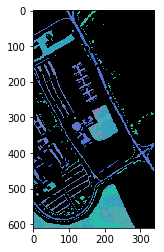

In [104]:
# create mask with same dimensions as image
mask = np.zeros_like(img_clustered)

# copy your image_mask to all dimensions (i.e. colors) of your image
for i in range(3): 
    mask[:,:,i] = htruth_mask.copy()

# apply the mask to your image
masked_image = clustered*mask

plt.imshow(masked_image)
plt.show()

In [105]:
hgtruth_load = sio.loadmat('PaviaGrTruth.mat')
hgtruth_mask = hgtruth_load['PaviaGrTruth']

martinIndex(hgtruth_mask, masked_image)*1000

165.14143083632007

Fuzzy C-Means clustering time to do: 89.51s


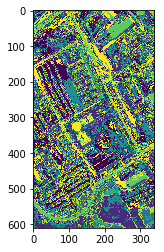

In [106]:
import skfuzzy
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

#Turn into grayscale
img_gray = rgb2gray(reduced_data_3D)

# Reshape data
img_flat = img_gray.reshape((1, -1))

n_clusters = 9

t0 = time.time()
# Run algorithm
fzz = skfuzzy.cluster.cmeans(img_flat, c = n_clusters, m = 2, error=0.005, maxiter=1000)
t1 = time.time()

#Find clustering from fuzzy segmentation
img_clustered = np.argmax(fzz[1], axis=0).astype(float)
img_clustered.shape = img_gray.shape

plt.imshow(img_clustered)
title = 'Fuzzy C-Means clustering time to do: %.2fs' % (t1 - t0)
print(title)
plt.show()

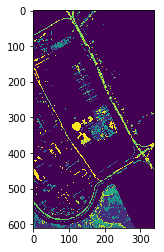

In [107]:
# # create mask with same dimensions as image
# mask = np.zeros_like(img_clustered)

# copy your image_mask to all dimensions (i.e. colors) of your image
# for i in range(3): 
#     mask[:,:,i] = htruth_mask.copy()

# apply the mask to your image
masked_image = img_clustered*htruth_mask

plt.imshow(masked_image)
plt.show()

In [108]:
hgtruth_load = sio.loadmat('PaviaGrTruth.mat')
hgtruth_mask = hgtruth_load['PaviaGrTruth']

martinIndex(hgtruth_mask, masked_image)*1000
masked_image.shape
# np.savetxt("foo.csv", masked_image, delimiter=",")

TypeError: 'float' object is not iterable

Spectral clustering time to do: 36.60s


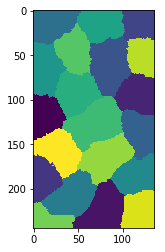

In [109]:
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

img_r = rescale(reduced_data_3D,0.4,mode='reflect')

#Turn into grayscale
img_gray = rgb2gray(img_r)

graph = image.img_to_graph(img_gray)#, mask=mask)

beta = 5
eps = 1e-6
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

n_clusters = 20

t0 = time.time()
img_clustered = spectral_clustering(graph, n_clusters=n_clusters, assign_labels = 'discretize')
t1 = time.time()
img_clustered = img_clustered.reshape(img_gray.shape)


title = 'Spectral clustering time to do: %.2fs' % (t1 - t0)
print(title)
plt.imshow(img_clustered)
plt.show()

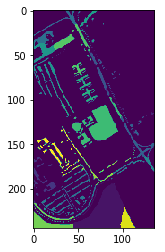

In [110]:
mask = rescale(htruth_mask,0.4,mode='reflect')

# apply the mask to your image
masked_image = img_clustered*mask

plt.imshow(masked_image)
plt.show()

Gaussian Mixture Model clustering time to do: 25.16s


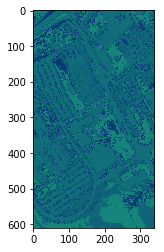

In [111]:
from sklearn import mixture

n_clusters = 9

gmm = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')

t0 = time.time()
# Run the algorithm
img_gmm = gmm.fit(img_data)
img_clustered = img_data[gmm.predict(img_data)].astype(float)
t1 = time.time()

# Reshape the data
img_clustered.shape = reduced_data_3D.shape

# Plot the data
plt.imshow(img_clustered)
title = 'Gaussian Mixture Model clustering time to do: %.2fs' % (t1 - t0)
print(title)
plt.show()

In [ ]:
img_clustered.shape

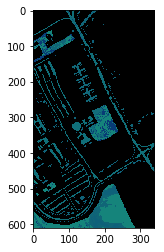

In [112]:
# create mask with same dimensions as image
mask = np.zeros_like(img_clustered)

# copy your image_mask to all dimensions (i.e. colors) of your image
for i in range(3): 
    mask[:,:,i] = htruth_mask.copy()
    
# apply the mask to your image
masked_image = img_clustered*mask

plt.imshow(masked_image)
plt.show()

In [113]:
hgtruth_load = sio.loadmat('PaviaGrTruth.mat')
hgtruth_mask = hgtruth_load['PaviaGrTruth']

martinIndex(hgtruth_mask, masked_image)*1000

159.94069664378935

# Things that need to get done:

#### Find a way to select the number of cluster. A posteriori will not work must be a priori. Some methods he mentioned:
        # Xie-Beni Index: https://programtalk.com/vs2/python/9922/pygmi/pygmi/clust/xie_beni.py/
        # Use objective function
        # Use scatter matrix
        
#### MyClustEvalRGB: Create RGB function to does the same as above for each cluster and combienes it back together 

#### MyClustEvalHyper: Create Hyperspectral function that does similar (skips step 3,4,5) but does this: 
        # For Hyperspectral multiply segmentation by the ground truth mask. 
        # Dont use connected compontens, use cluster labels. Set number of cluster to 9
        # This is doneish, but I would like to run it throught color separator to recolor it into nicer colors
        
#### Run the experiments for each algorithm

#### Finish the report and consolidate it


In [5]:
# %load main.py
import numpy as np
import scipy.io as sio
import time
import sys
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from minisom import MiniSom
import skfuzzy
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
from sklearn import mixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from skimage.transform import rescale
from skimage import measure
from skimage import morphology
from scipy.ndimage.filters import gaussian_filter
from kmeans import MyKmeans8
from som import MySOM8
from fcm import MyFCM8
from spectral import MySpectral8
from gmm import MyGMM8


def MyClust8(Image, Algorithm="Kmeans", ImageType="RGB", NumClusts=3):
    if Algorithm == "Kmeans":
        return MyKmeans8(Image, ImageType, NumClusts)
    elif Algorithm == "SOM":
        return MySOM8(Image, ImageType, NumClusts)
    elif Algorithm == "FCM":
        return MyFCM8(Image, ImageType, NumClusts)
    elif Algorithm == "Spectral":
        return MySpectral8(Image, ImageType, NumClusts)
    elif Algorithm == "GMM":
        return MyGMM8(Image, ImageType, NumClusts)
    else:
        print ("Wrong Choice")
        sys.exit()


img_clust = MyClust8("ImsAndSegs/ImsAndTruths2092.mat", Algorithm="Kmeans",
                     ImageType="RGB", NumClusts=3)

plt.imshow(img_clust)
plt.show()


MyClust8("ImsAndSegs/ImsAndTruths100075.mat", "GMM", "RGB", 3)


NameError: name 'img_r' is not defined